## CS-471: Machine Learning
### **Submitted By**:
#### **Name**: Ayesh Ahmad
#### **CMS**: 365966
#### **Class**: BESE-12A
---
## Lab 10
#### Develop a machine learning model on the UCI adult income dataset. The end goal is to develop a model that successfully classify the income range and achieves the best performance on the data. The choice of the algorithm and the pipeline steps should be logical and must be supported with logical explanation and proper headings. Compare your results with at least 3-5 other techniques and analyze the results obtained.

##### Imports
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

##### Data Ingestion and Analysis
---

Load and display the dataset. The train and test set are concatenated for easier data manipulation.

In [2]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

train_data = pd.read_csv('./adult/adult.data', names=columns, delimiter=',\s', engine='python')
test_data = pd.read_csv('./adult/adult.test', names=columns, delimiter=',\s', engine='python')
data = pd.concat([train_data, test_data])

data.head()

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ayesh\AppData\Local\Temp\ipykernel_13668\1498263010.py:7: SyntaxWarning: invalid escape sequence '\s'
  train_data = pd.read_csv('./adult/adult.data', names=columns, delimiter=',\s', engine='python')
C:\Users\ayesh\AppData\Local\Temp\ipykernel_13668\1498263010.py:8: SyntaxWarning: invalid escape sequence '\s'
  test_data = pd.read_csv('./adult/adult.test', names=columns, delimiter=',\s', engine='python')


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [3]:
data.shape

(48843, 15)

Check for inconsistencies in dataset.

In [4]:
data.isin(['?']).sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
income               0
dtype: int64

In [5]:
info = pd.DataFrame()
info["IsNull"] = data.isnull().sum()
info["IsNa"] = data.isna().sum()
info["Duplicate"] = data.apply(lambda x: x.duplicated().sum())
info["Unique"] = data.apply(lambda x: x.nunique())
info["Min"] = data.select_dtypes(include=[np.number]).min()
info["Max"] = data.select_dtypes(include=[np.number]).max()

info.T

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
IsNull,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
IsNa,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Duplicate,48696.0,48833.0,20319.0,48826.0,48826.0,48835.0,48827.0,48836.0,48837.0,48840.0,48719.0,48743.0,48746.0,48800.0,48838.0
Unique,147.0,9.0,28523.0,16.0,16.0,7.0,15.0,6.0,5.0,2.0,123.0,99.0,96.0,42.0,4.0
Min,NaN,NaN,12285.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN
Max,NaN,NaN,1490400.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,99999.0,4356.0,99.0,NaN,NaN


Drop all inconsistent rows.

In [6]:
df = data.copy()
df.dropna(how='any',inplace=True)
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


In [7]:
df = df.drop_duplicates()
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


In [8]:
mask = df.applymap(lambda x: x == '?').any(axis=1)
df = df[~mask]
df

C:\Users\ayesh\AppData\Local\Temp\ipykernel_13668\4235333578.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df.applymap(lambda x: x == '?').any(axis=1)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,33,Private,245211.0,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K.
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


##### Feature Engineering
---

Text(0.5, 1.0, 'Histogram')

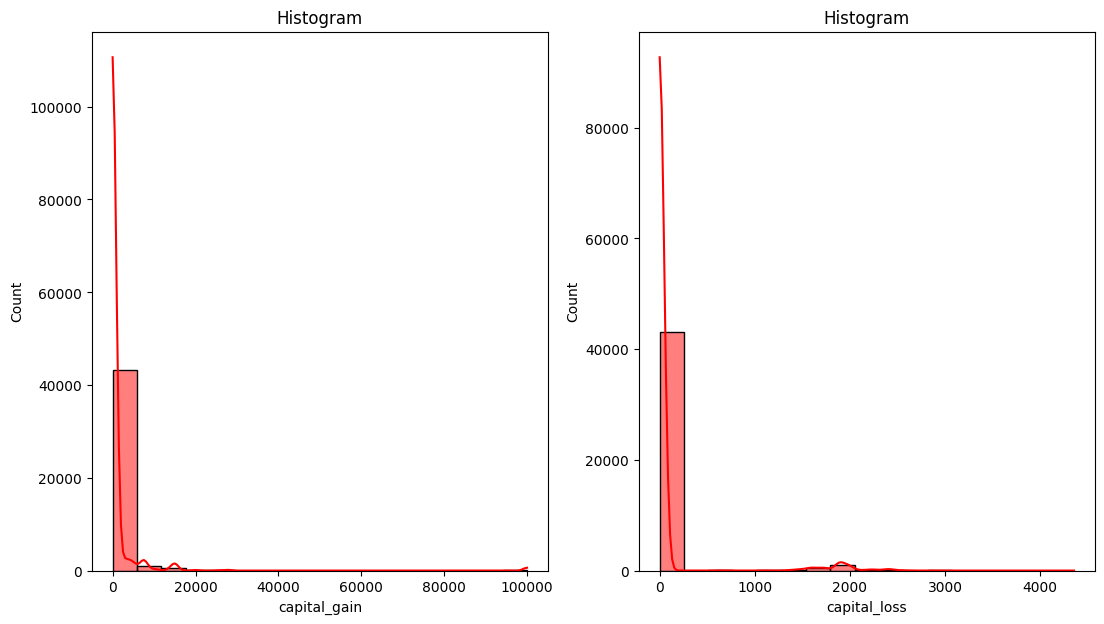

In [9]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)
sns.histplot(df['capital_gain'], kde = True,color='r')
plt.title('Histogram')
plt.subplot(1, 3, 2)
sns.histplot(df['capital_loss'], kde = True,color='r')
plt.title('Histogram')

75% does not have capital_gain or capital_loss. Making both a skewed or irrelevant feature which we can drop. education_num is also dropped due to it being redundant information.

In [10]:
df = df.drop(['education_num', 'capital_gain', 'capital_loss'], axis=1)

Reduce categorical features by making larger feature brackets.

In [11]:
education_mapping = {
    'Preschool': 'dropout',
    '10th': 'dropout',
    '11th': 'dropout',
    '12th': 'dropout',
    '1st-4th': 'dropout',
    '5th-6th': 'dropout',
    '7th-8th': 'dropout',
    '9th': 'dropout',
    'HS-grad': 'Highschool',
    'Some-college': 'College',
    'Assoc-acdm': 'College',
    'Assoc-voc': 'College',
    'Bachelors': 'Bachelors',
    'Masters': 'Masters',
    'Prof-school': 'Masters',
    'Doctorate': 'Doctorate'
}

df['education'] = df['education'].replace(education_mapping)
df

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,State-gov,77516.0,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13.0,United-States,<=50K
2,38,Private,215646.0,Highschool,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,<=50K
3,53,Private,234721.0,dropout,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,33,Private,245211.0,Bachelors,Never-married,Prof-specialty,Own-child,White,Male,40.0,United-States,<=50K.
16277,39,Private,215419.0,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,36.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40.0,United-States,<=50K.


In [12]:
marital_status_mapping = {
    'Never-married': 'NotMarried',
    'Married-AF-spouse': 'Married',
    'Married-civ-spouse': 'Married',
    'Married-spouse-absent': 'NotMarried',
    'Separated': 'Separated',
    'Divorced': 'Separated',
    'Widowed': 'Widowed'
}

df['marital_status'] = df['marital_status'].replace(marital_status_mapping)
df

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,State-gov,77516.0,Bachelors,NotMarried,Adm-clerical,Not-in-family,White,Male,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,Married,Exec-managerial,Husband,White,Male,13.0,United-States,<=50K
2,38,Private,215646.0,Highschool,Separated,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,<=50K
3,53,Private,234721.0,dropout,Married,Handlers-cleaners,Husband,Black,Male,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,Married,Prof-specialty,Wife,Black,Female,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,33,Private,245211.0,Bachelors,NotMarried,Prof-specialty,Own-child,White,Male,40.0,United-States,<=50K.
16277,39,Private,215419.0,Bachelors,Separated,Prof-specialty,Not-in-family,White,Female,36.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,Married,Prof-specialty,Husband,White,Male,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,Separated,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40.0,United-States,<=50K.


In [13]:
df['hours_per_week_bin'] = pd.cut(df['hours_per_week'], 10)
df['hours_per_week'] = df['hours_per_week']
df.age = df.age.astype(float)
df['hours_per_week'] = df['hours_per_week'].astype(float)
df['age_hours'] = df['age']*df['hours_per_week']
df['age_hours_bin'] = pd.cut(df['age_hours'], 10)
df['income'].replace('<=50K.', '<=50K', inplace=True)
df['income'].replace('>50K.', '>50K', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45194 entries, 0 to 16281
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 45194 non-null  float64 
 1   workclass           45194 non-null  object  
 2   fnlwgt              45194 non-null  float64 
 3   education           45194 non-null  object  
 4   marital_status      45194 non-null  object  
 5   occupation          45194 non-null  object  
 6   relationship        45194 non-null  object  
 7   race                45194 non-null  object  
 8   sex                 45194 non-null  object  
 9   hours_per_week      45194 non-null  float64 
 10  native_country      45194 non-null  object  
 11  income              45194 non-null  object  
 12  hours_per_week_bin  45194 non-null  category
 13  age_hours           45194 non-null  float64 
 14  age_hours_bin       45194 non-null  category
dtypes: category(2), float64(4), object(9)
mem

C:\Users\ayesh\AppData\Local\Temp\ipykernel_13668\2448731884.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['income'].replace('<=50K.', '<=50K', inplace=True)
C:\Users\ayesh\AppData\Local\Temp\ipykernel_13668\2448731884.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

Final feature analysis.

In [14]:
print('workclass',df.workclass.unique())
print('\neducation',df.education.unique())
print('\nmarital_status',df['marital_status'].unique())
print('\noccupation',df.occupation.unique())
print('\nrelationship',df.relationship.unique())
print('\nrace',df.race.unique())
print('\nsex',df.sex.unique())
print('\nnative_country',df['native_country'].unique())
print('\nincome',df.income.unique())

workclass ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay']

education ['Bachelors' 'Highschool' 'dropout' 'Masters' 'College' 'Doctorate']

marital_status ['NotMarried' 'Married' 'Separated' 'Widowed']

occupation ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Transport-moving' 'Farming-fishing'
 'Machine-op-inspct' 'Tech-support' 'Craft-repair' 'Protective-serv'
 'Armed-Forces' 'Priv-house-serv']

relationship ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

race ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']

sex ['Male' 'Female']

native_country ['United-States' 'Cuba' 'Jamaica' 'India' 'Mexico' 'Puerto-Rico'
 'Honduras' 'England' 'Canada' 'Germany' 'Iran' 'Philippines' 'Poland'
 'Columbia' 'Cambodia' 'Thailand' 'Ecuador' 'Laos' 'Taiwan' 'Haiti'
 'Portugal' 'Dominican-Republic' 'El-Salvador' 'France' 'Guatemala'
 'Italy' 'China' 'South'

##### Data Preprocessing
---

Label Encoding

In [15]:
df = df.apply(LabelEncoder().fit_transform)
df

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income,hours_per_week_bin,age_hours,age_hours_bin
0,22,5,3217,0,1,0,1,4,1,39,38,0,3,655,1
1,33,4,3519,0,0,3,0,4,1,12,38,0,1,302,0
2,21,2,17196,3,2,5,1,4,1,39,38,0,3,644,1
3,36,2,18738,5,0,5,0,2,1,39,38,0,3,847,2
4,11,2,23828,0,0,9,5,2,0,39,4,0,3,494,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,16,2,19515,0,1,9,3,4,1,39,38,0,3,572,1
16277,22,2,17175,0,2,9,1,4,0,35,38,0,3,601,1
16279,21,2,24889,0,0,9,0,4,1,49,38,0,4,775,2
16280,27,2,3561,0,2,0,3,1,1,39,38,0,3,725,1


Coorelation Matrix

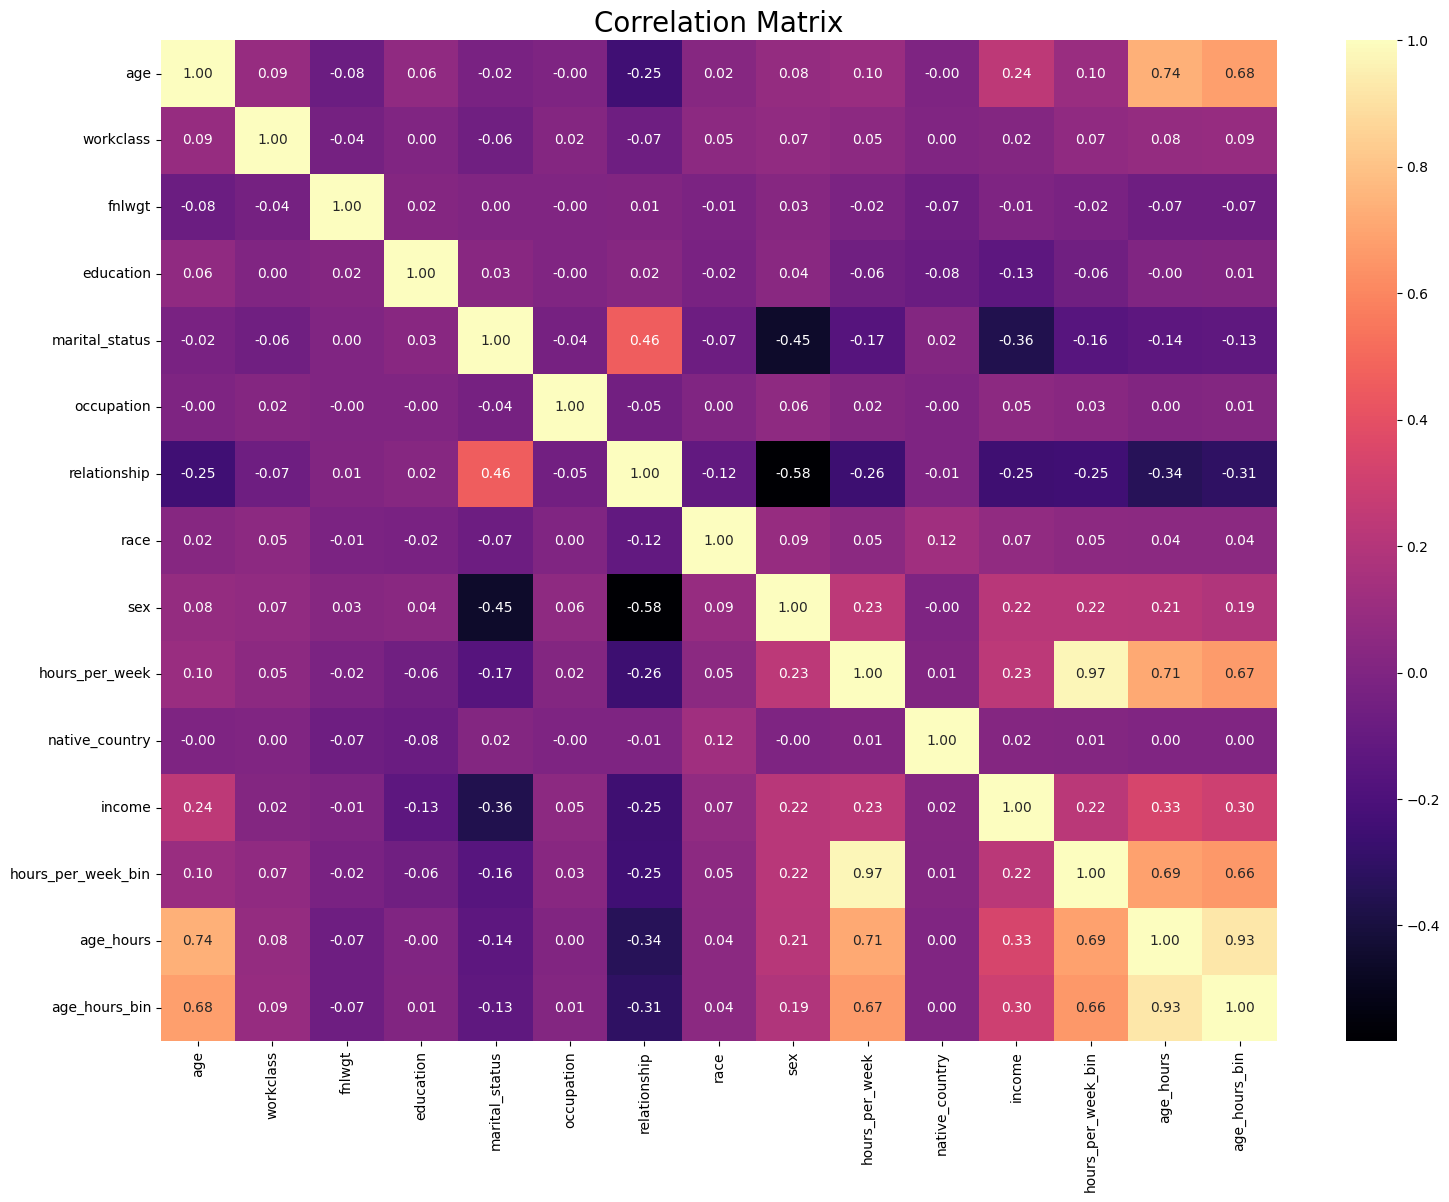

In [16]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

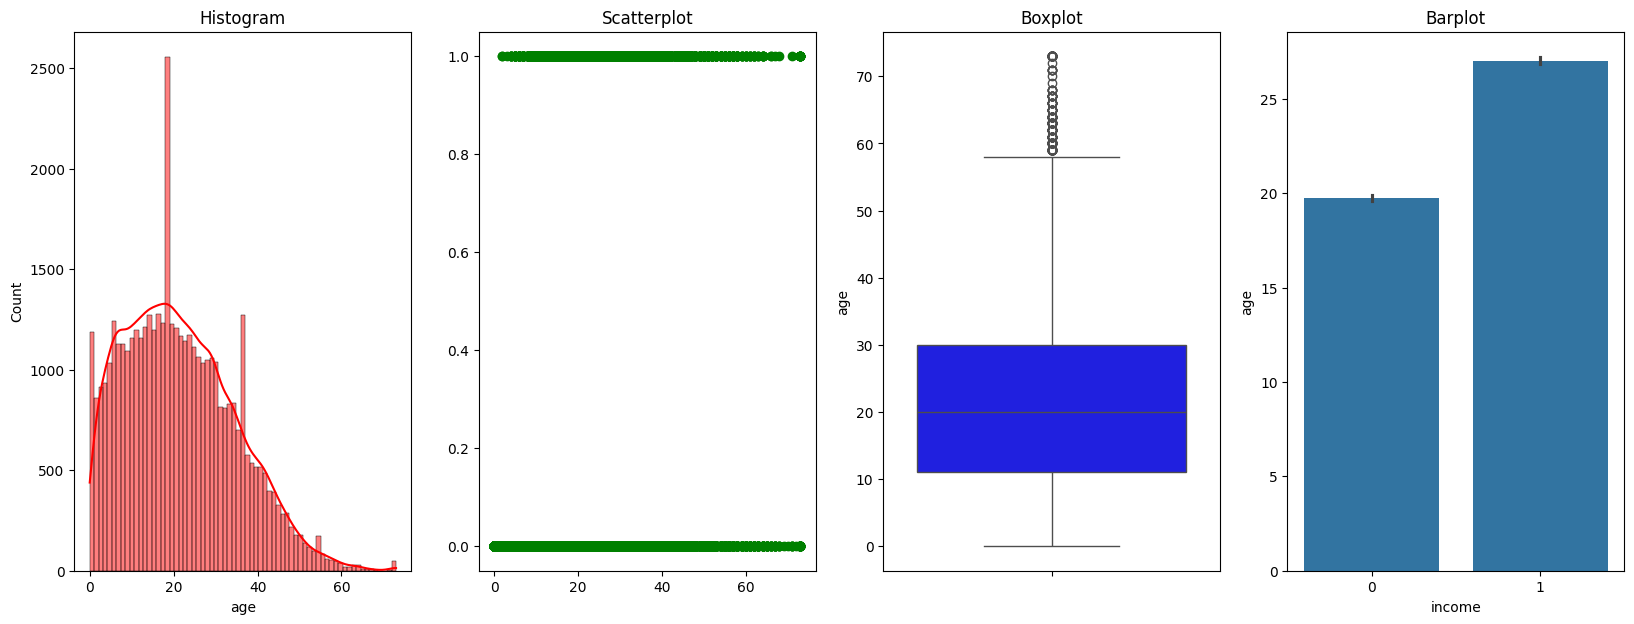

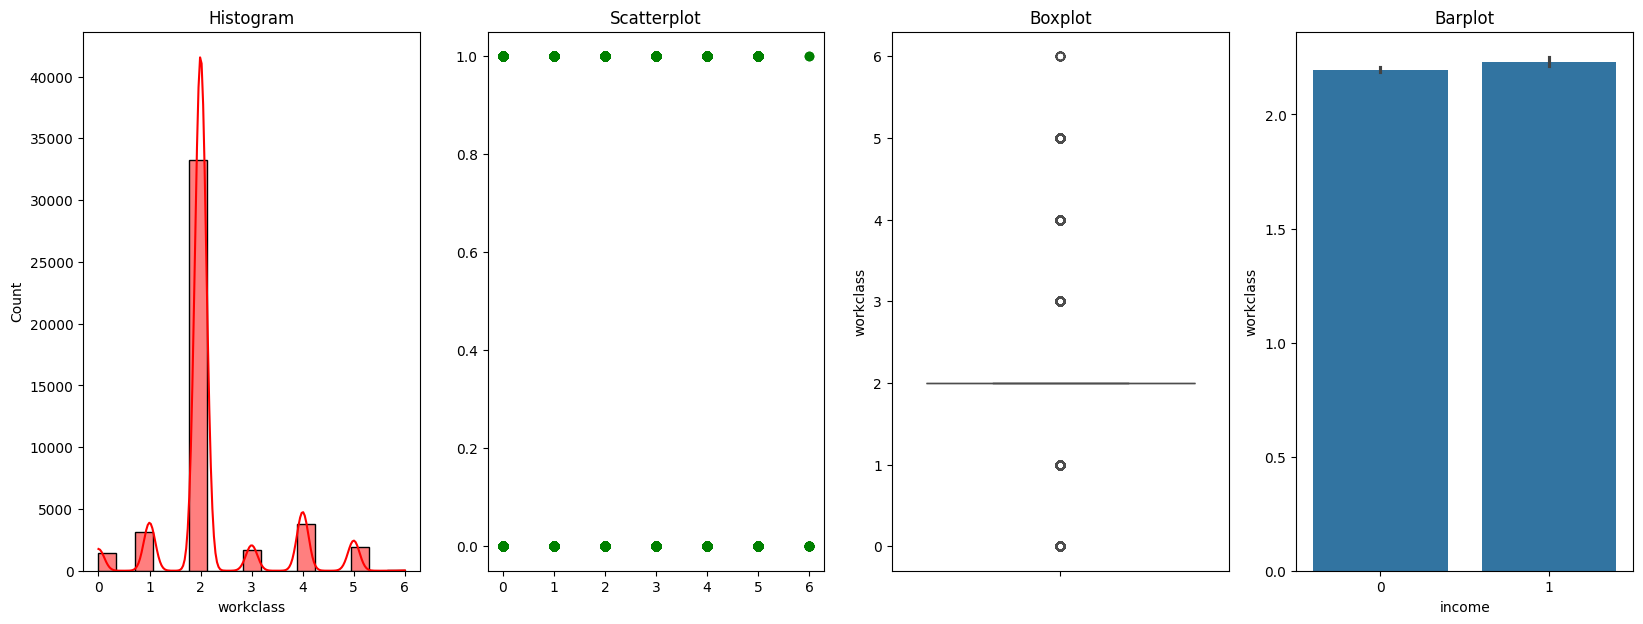

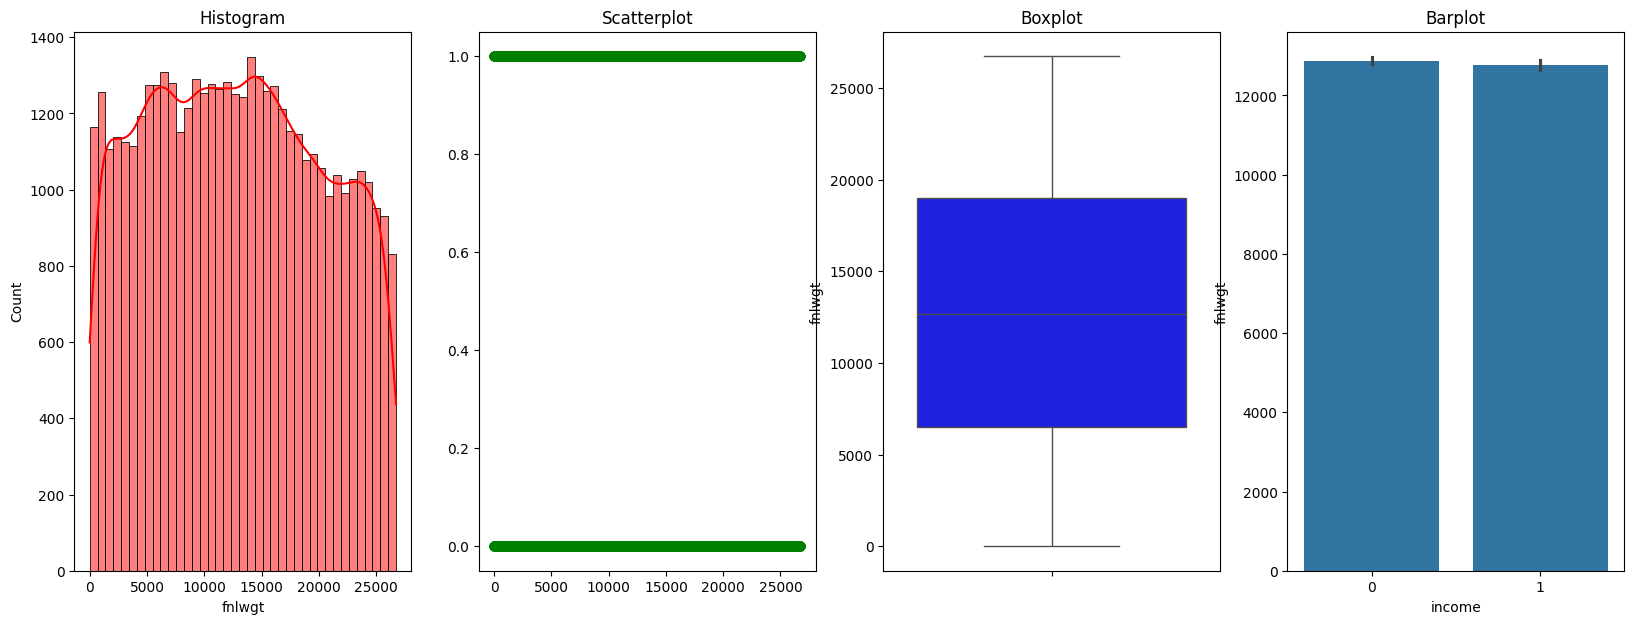

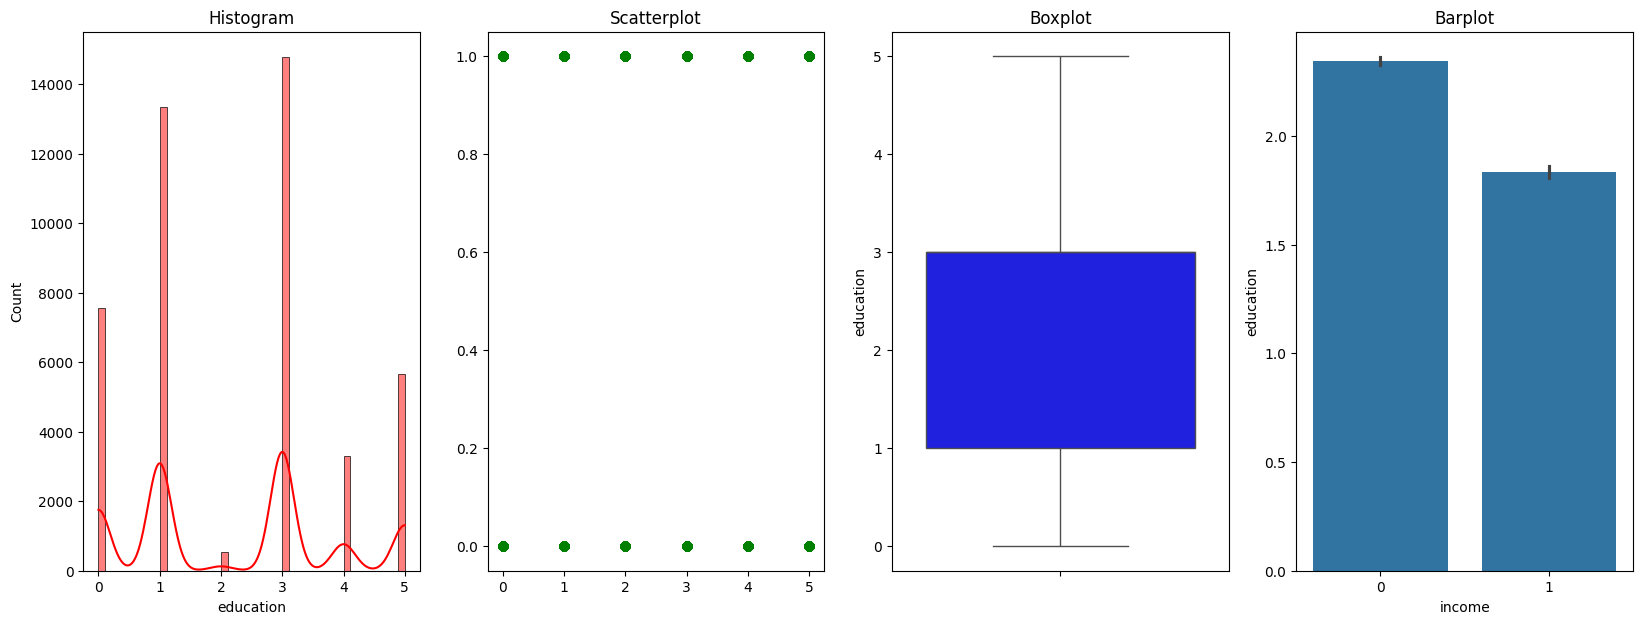

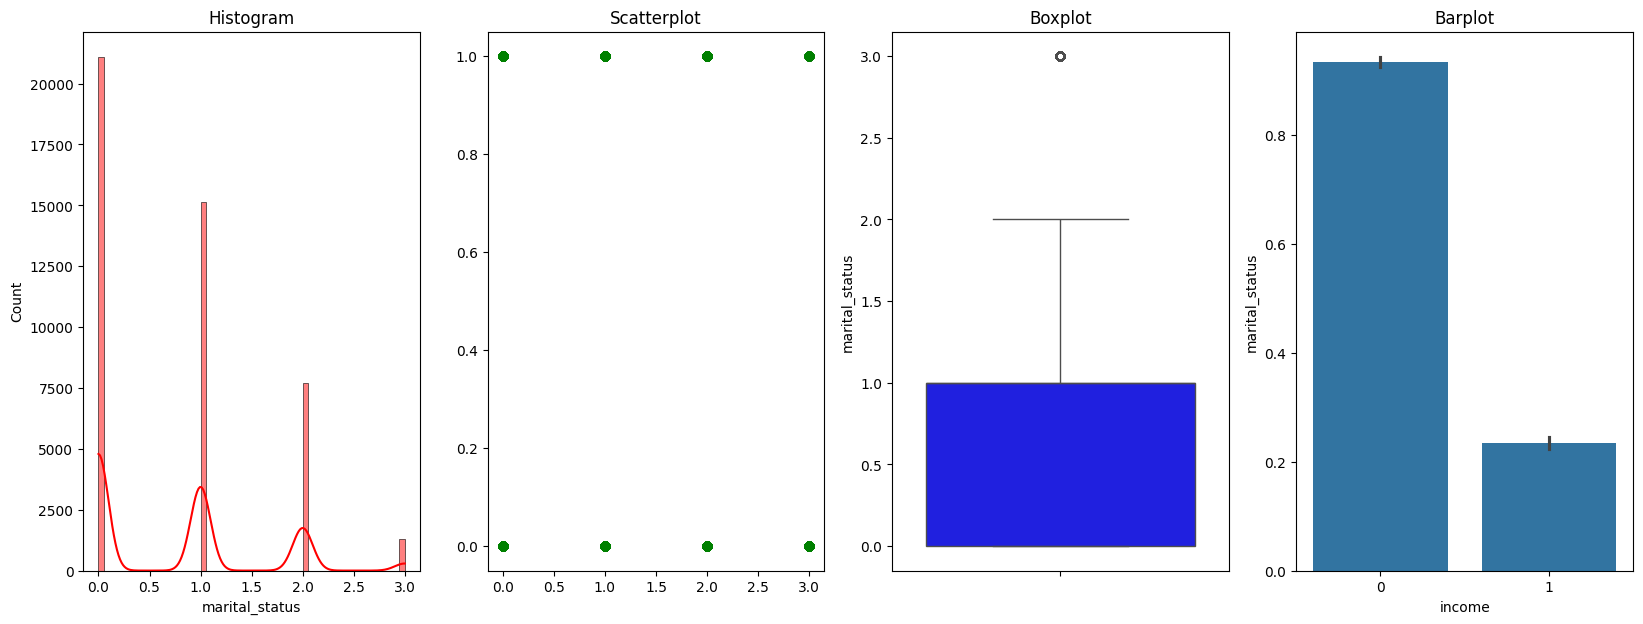

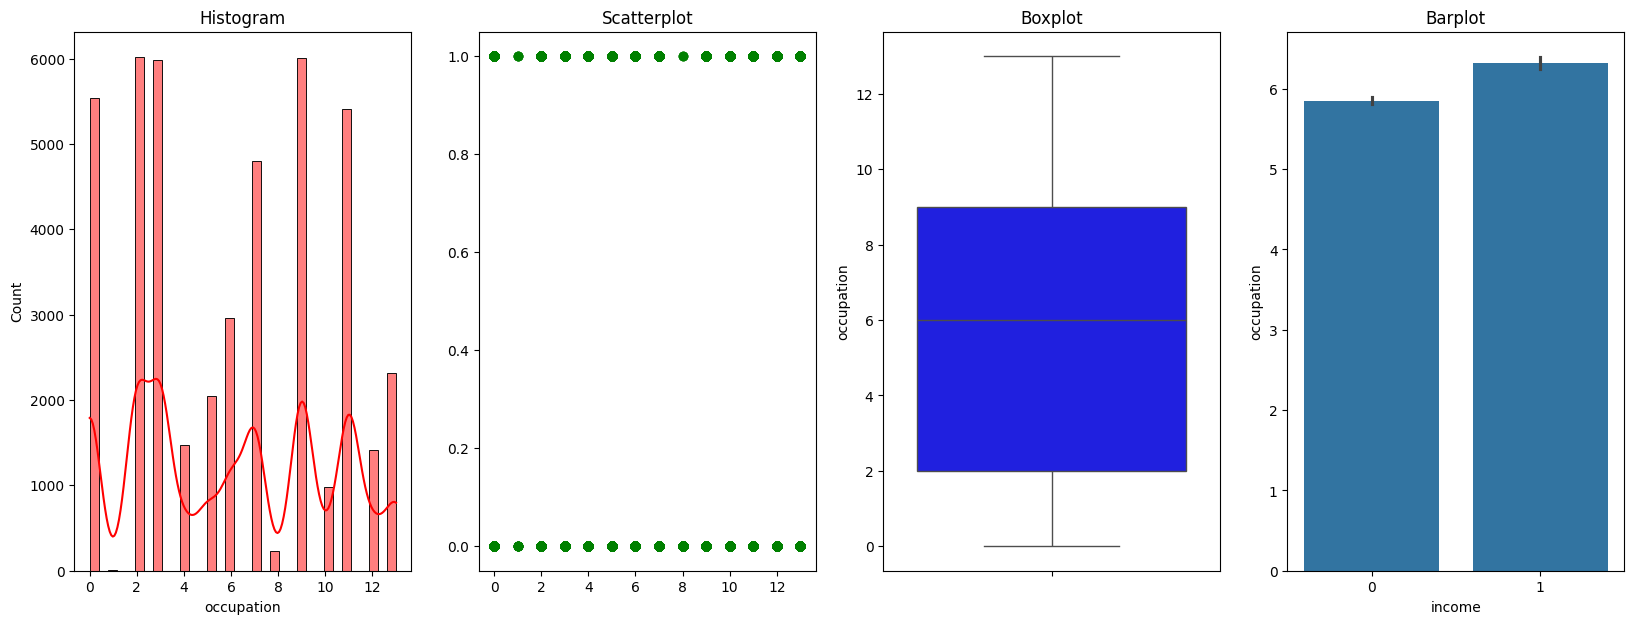

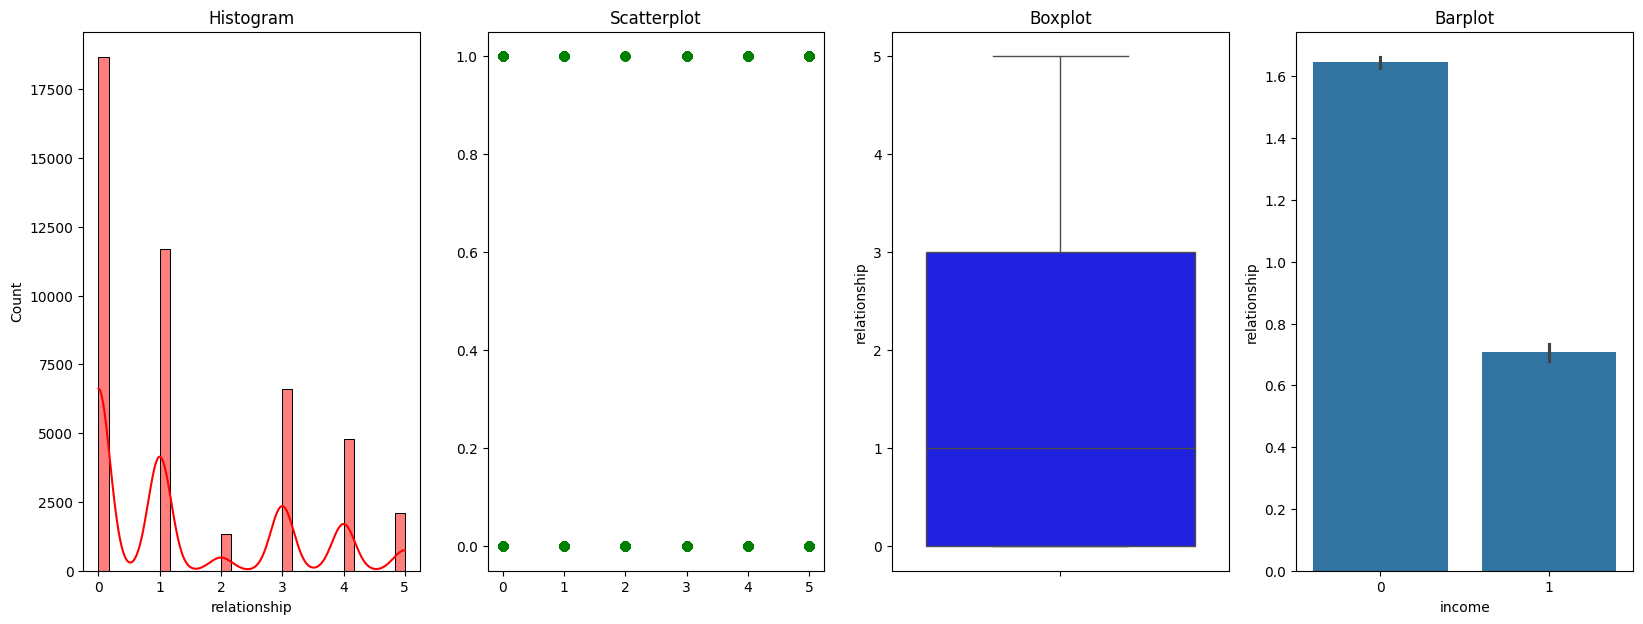

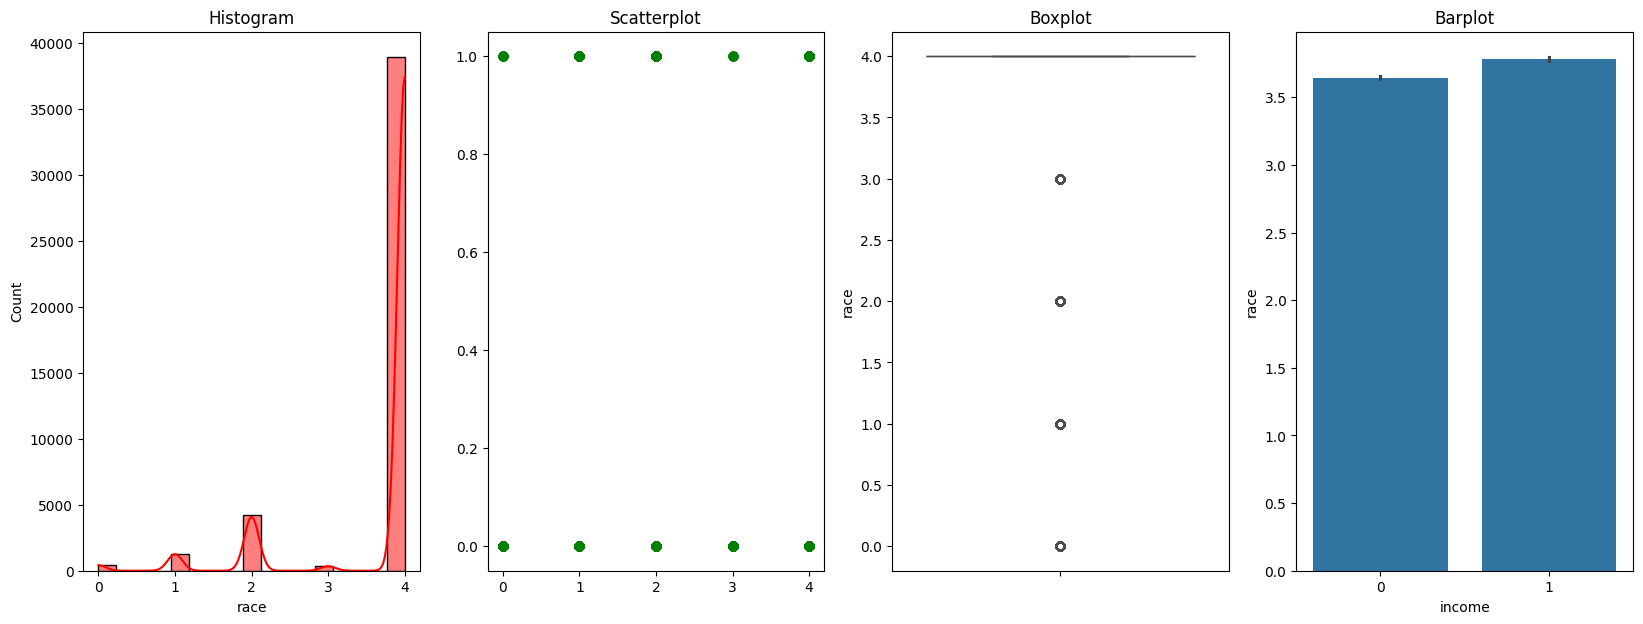

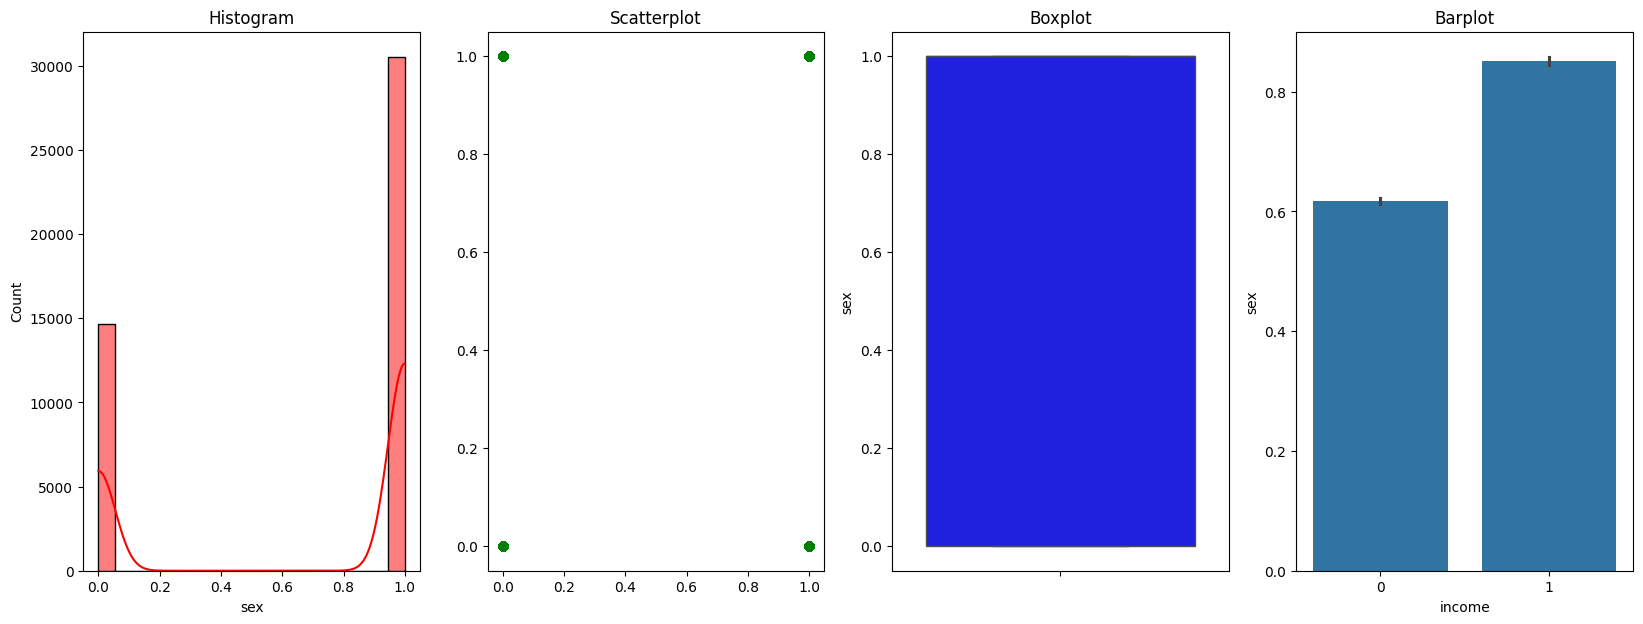

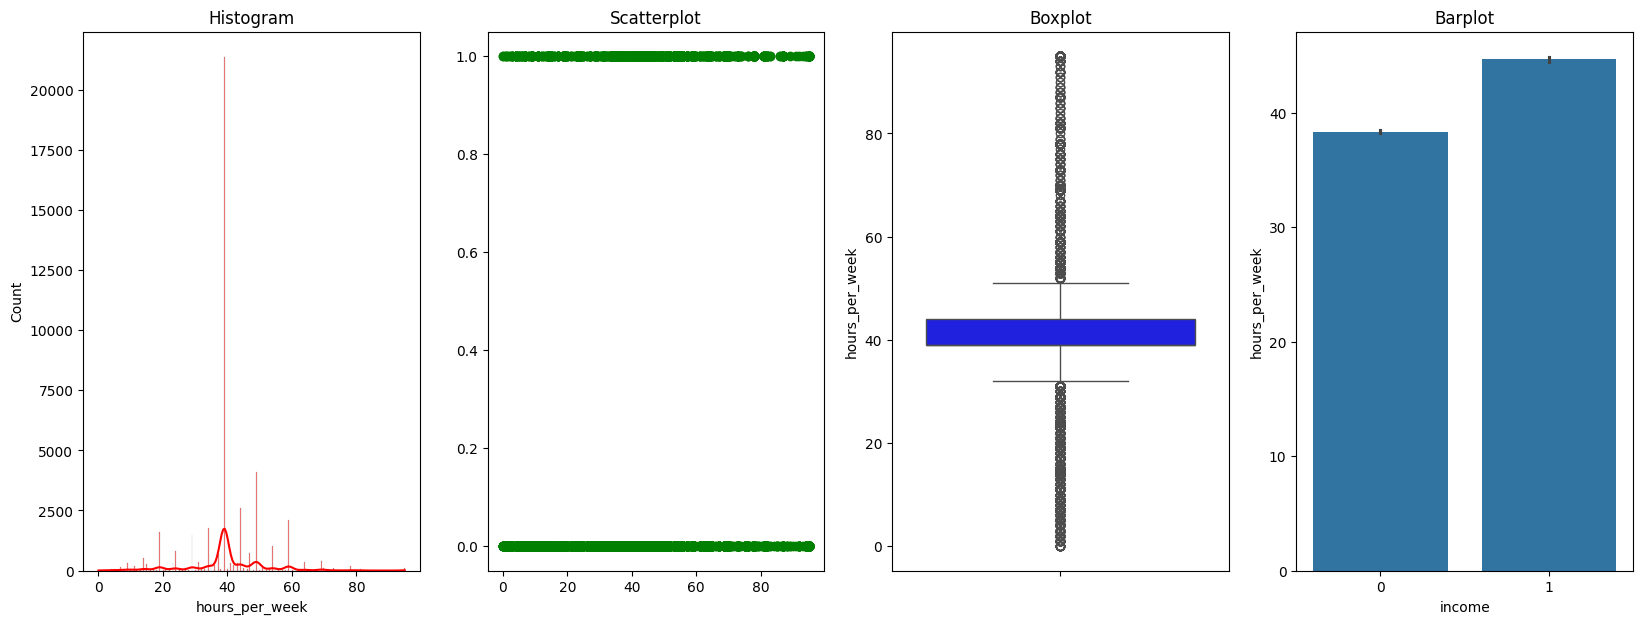

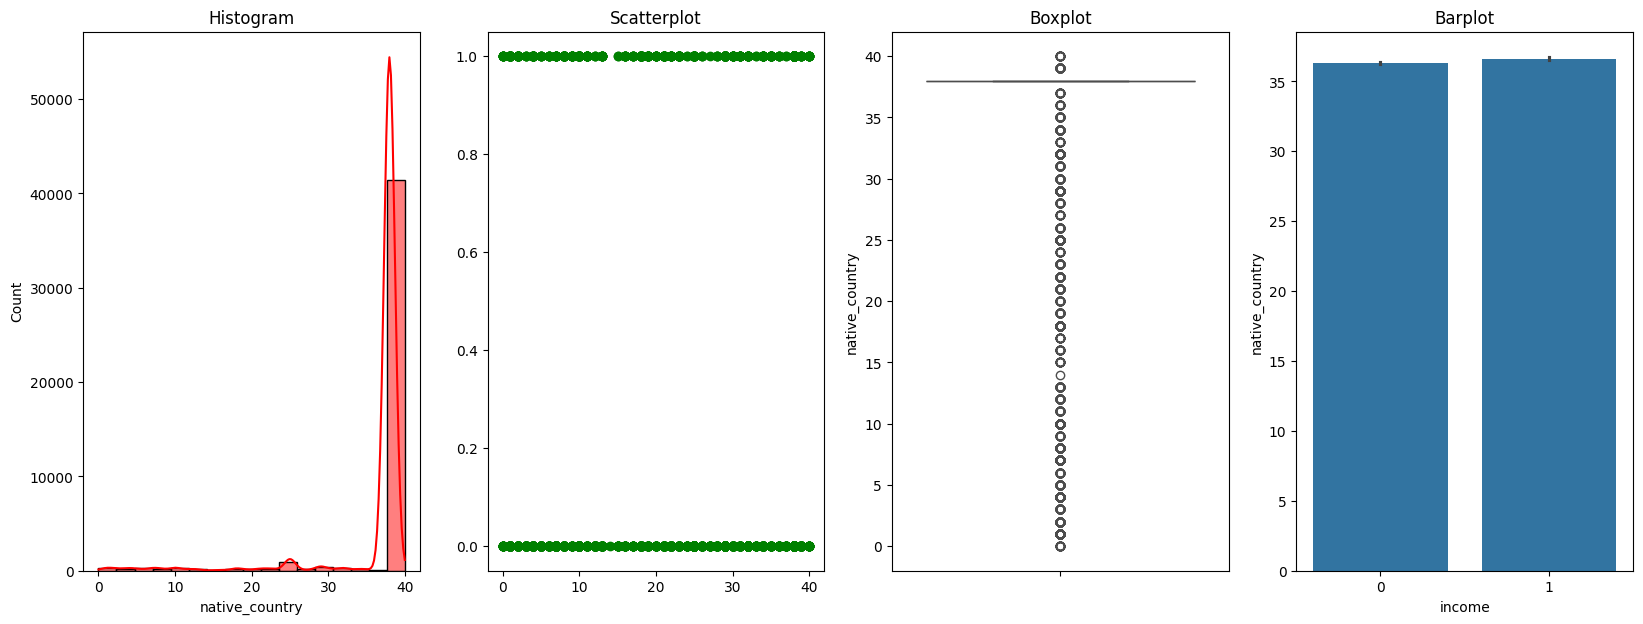

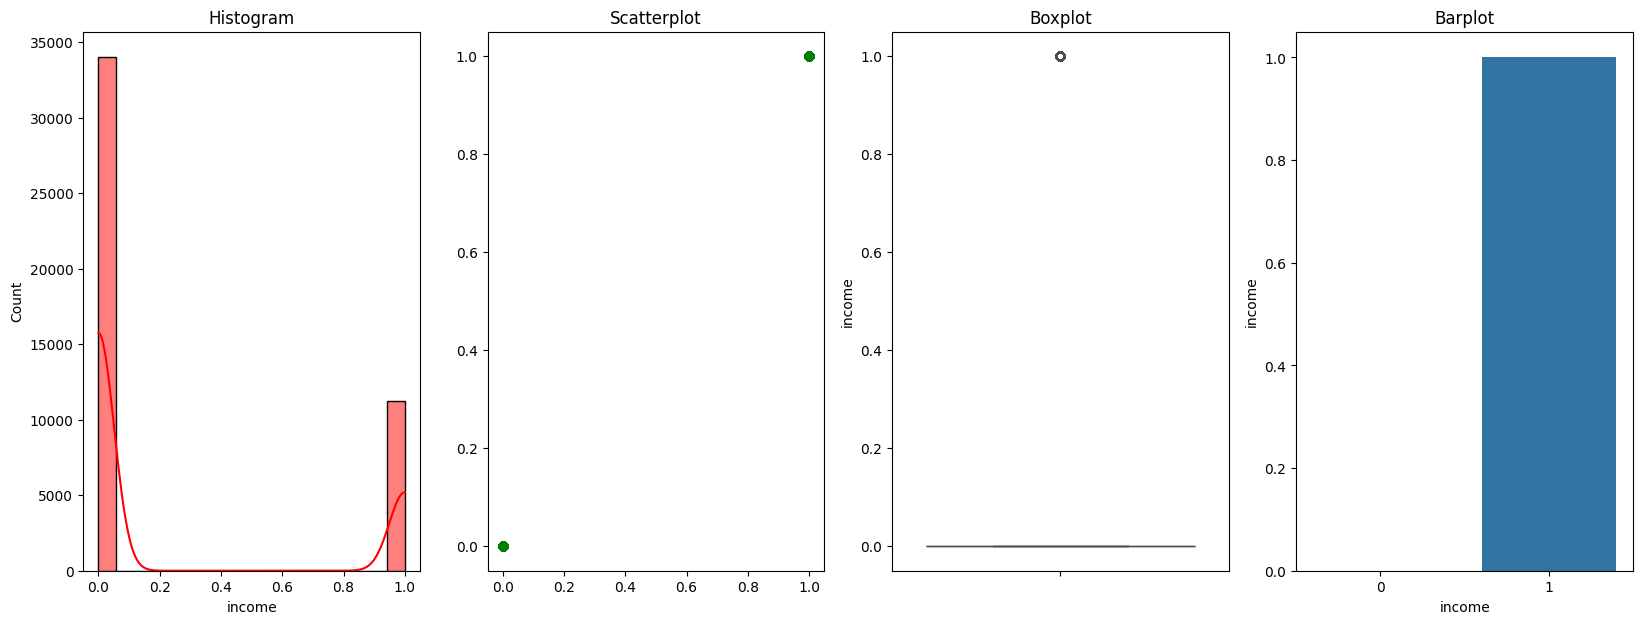

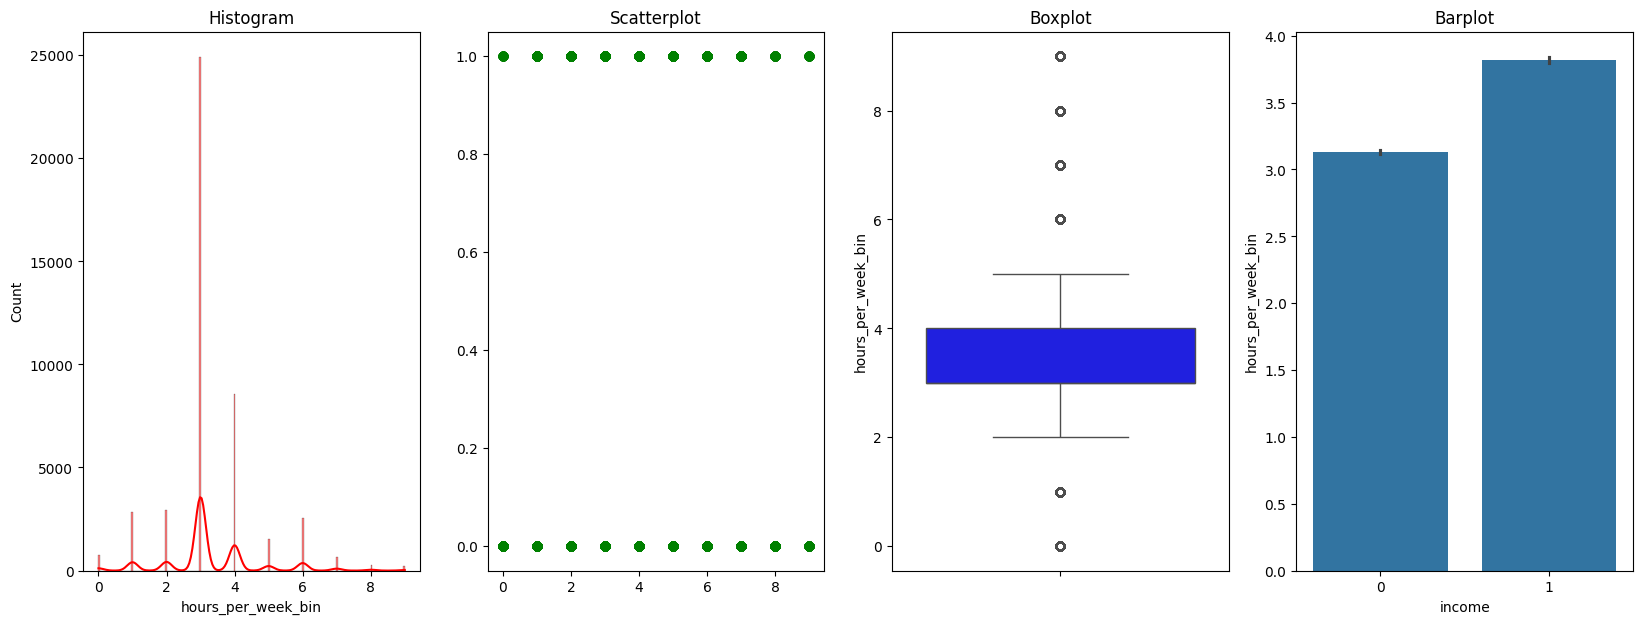

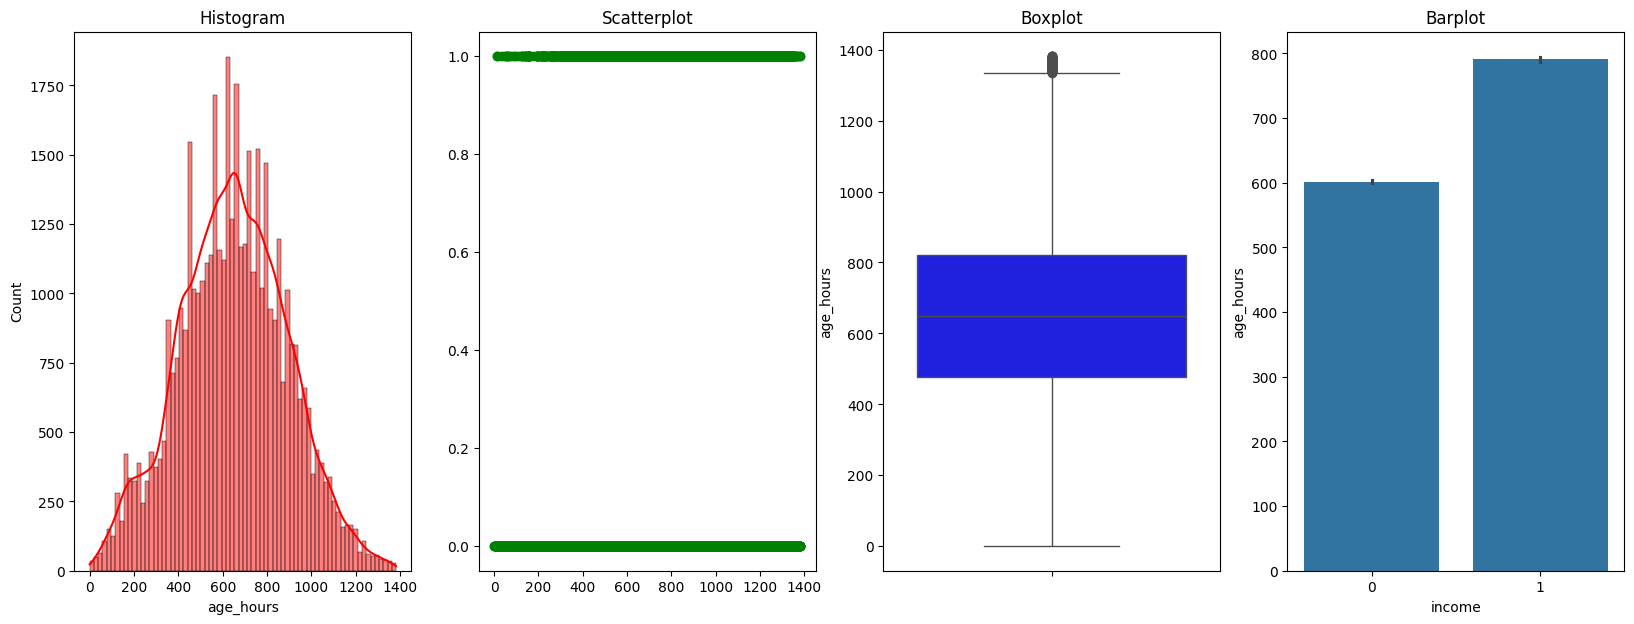

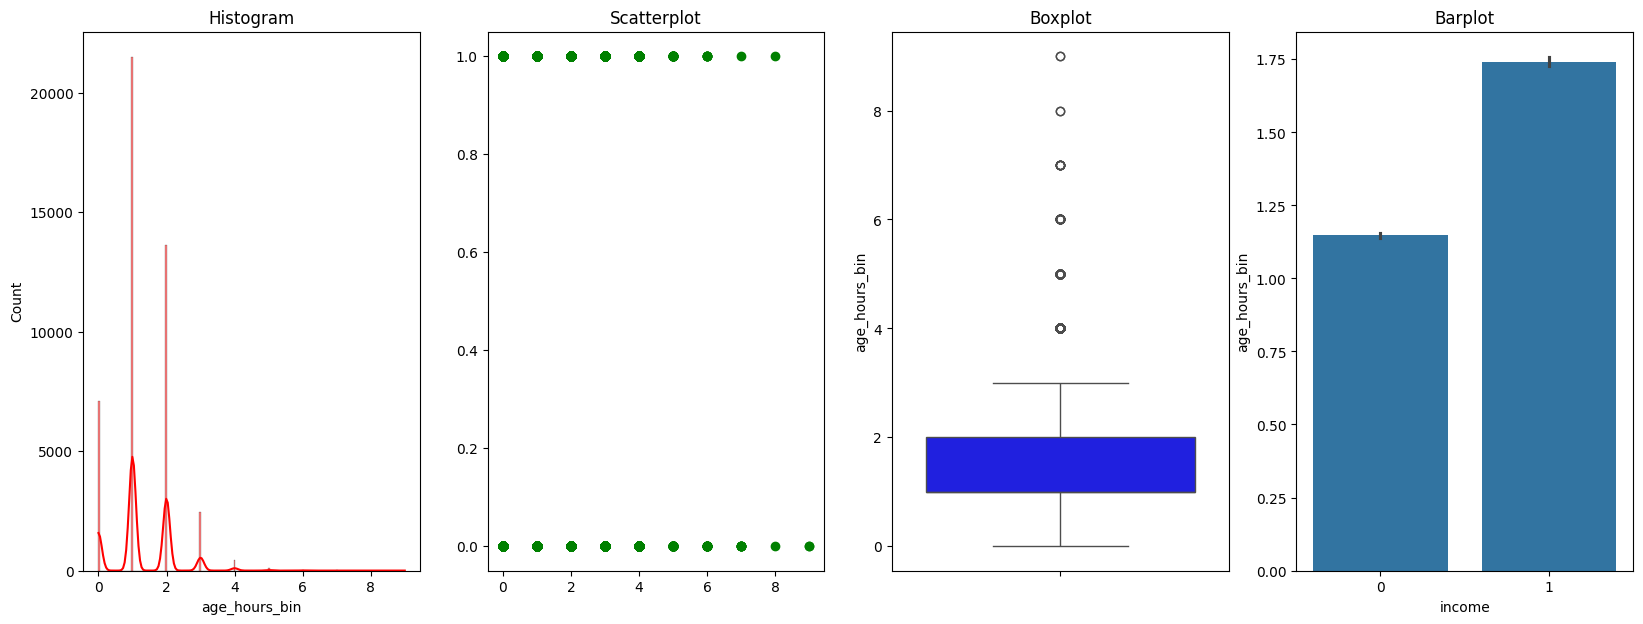

In [17]:
def diagnostic_plots(df, variable,target):
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], kde = True,color='r')
    plt.title('Histogram')

    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')

    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')

    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)
    plt.title('Barplot')

    plt.show()

for col in df:
    diagnostic_plots(df,col,'income')

Feature and label extraction.

In [18]:
X = df.drop(columns={"income"},axis=1)
y = df["income"].values.reshape(-1,1)

Train/Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (36155, 14)
y_train shape: (36155, 1)
X_test shape: (9039, 14)
y_test shape: (9039, 1)


Scale and transform data

In [20]:
st = MinMaxScaler()
X_train = st.fit_transform(X_train)
X_test = st.fit_transform(X_test)

##### Logistic Regression
---

In [169]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  
    'max_iter': [100, 200, 300, 400, 500]  
}

lr = LogisticRegression(random_state=0)
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train.ravel())
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters found:  {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}
Accuracy: 0.7938133770357472
Precision: 0.6163318211276734
Recall: 0.4009274873524452
F1 Score: 0.48582375478927203


##### Support Vector Machine
---

In [170]:
param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf', 'poly'], 
    'gamma': ['scale', 'auto'],  
}

svm = SVC()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train.ravel())
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_svm_clf = grid_search.best_estimator_
y_pred_svm = best_svm_clf.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("SVM - Accuracy:", accuracy_svm)
print("SVM - Precision:", precision_svm)
print("SVM - Recall:", recall_svm)
print("SVM - F1 Score:", f1_svm)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM - Accuracy: 0.8141964560073748
SVM - Precision: 0.6539735099337748
SVM - Recall: 0.49957841483979765
SVM - F1 Score: 0.5664435946462715


##### K-Nearest Neighbor
---

In [171]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9], 
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train.ravel())
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_knn_clf = grid_search.best_estimator_
y_pred_knn = best_knn_clf.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print("KNN - Accuracy:", accuracy_knn)
print("KNN - Precision:", precision_knn)
print("KNN - Recall:", recall_knn)
print("KNN - F1 Score:", f1_knn)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:  {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
KNN - Accuracy: 0.8126600430195636
KNN - Precision: 0.6391594054331112
KNN - Recall: 0.5257166947723441
KNN - F1 Score: 0.5769141799676151


##### Random Forest
---

In [173]:
param_grid = {
    'n_estimators': [100, 300, 500],  
    'max_depth': [10, 30, 50, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train.ravel())
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_rf_clf = grid_search.best_estimator_

y_pred_rf = best_rf_clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest - Accuracy:", accuracy_rf)
print("Random Forest - Precision:", precision_rf)
print("Random Forest - Recall:", recall_rf)
print("Random Forest - F1 Score:", f1_rf)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - Accuracy: 0.8321212741985046
Random Forest - Precision: 0.6988605534454694
Random Forest - Recall: 0.5430016863406408
Random Forest - F1 Score: 0.6111506524317912


##### Multi-Layer Perceptron
---

In [21]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', random_state=0)

mlp.fit(X_train, y_train.ravel())

y_pred_mlp = mlp.predict(X_test)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print("Neural Network - Accuracy:", accuracy_mlp)
print("Neural Network - Precision:", precision_mlp)
print("Neural Network - Recall:", recall_mlp)
print("Neural Network - F1 Score:", f1_mlp)

Neural Network - Accuracy: 0.8264188516428809
Neural Network - Precision: 0.6741048261546445
Neural Network - Recall: 0.5799107142857143
Neural Network - F1 Score: 0.6234701223902088


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


##### Results and Conlusion

| Model            | Best Parameters                                          | Accuracy | Precision | Recall | F1 Score | Training Time |
|------------------|----------------------------------------------------------|----------|-----------|--------|----------|---------------|
| Logistic Regression | {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}         | 0.7938   | 0.6163    | 0.4009 | 0.4858   | 22.5s         |
| SVM              | {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}            | 0.8142   | 0.6540    | 0.4996 | 0.5664   | 7m 52.1s      |
| KNN              | {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'} | 0.8127   | 0.6392    | 0.5257 | 0.5769   | 1m 5.5s       |
| Random Forest    | {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300} | 0.8321 | 0.6989 | 0.5430 | 0.6112 | 19m 36.4s |
| Neural Network   | -                                                        | 0.8264   | 0.6741    | 0.5799 | 0.6235   | 40.0s         |


In this comparison of different machine learning models for the task, the random forest model performed the best in terms of accuracy, precision, recall, and F1 score, achieving an accuracy of 83.21%. The random forest model's performance can be attributed to its ability to handle complex relationships in the data, thanks to its ensemble of decision trees. However, it's worth noting that the random forest model also took the longest to train, with a training time of 19 minutes and 36.4 seconds. The neural network model also performed well, with an accuracy of 82.64%, but it had the advantage of a much shorter training time compared to the random forest model, taking only 40.0 seconds. Overall, the choice of model should consider both performance metrics and practical considerations such as training time and computational resources.